## CS310 Natural Language Processing
## Lab 11: Explore Natural Language Generation

In this lab, we will practice using pre-trained transformer-based language models for natural language generation tasks.

In [2]:
import torch
import torch.nn.functional as F
import random
import numpy as np

## T1. Explore Pretrained GPT-2 Model

In this task, you will explore the GPT-2 model using the `transformers` library.

Just like in the previous lab, you will need to download the pretrained model and unzip it to `./gpt2zh`. 

Note that this is not the original version of GPT-2 provided by OpenAI (https://huggingface.co/openai-community/gpt2), but a fine-tuned version for Chinese text generation.

In [3]:
from transformers import AutoTokenizer, GPT2LMHeadModel

gpt2_tokenizer = AutoTokenizer.from_pretrained("./gpt2zh")
gpt2_model = GPT2LMHeadModel.from_pretrained("./gpt2zh")
# Evaluation mode
gpt2_model = gpt2_model.half()

print('vocab size:', gpt2_tokenizer.vocab_size)
print(f'special token {gpt2_tokenizer.sep_token}:', gpt2_tokenizer.sep_token_id)
print(f'special token {gpt2_tokenizer.cls_token}:', gpt2_tokenizer.cls_token_id)
print(f'special token {gpt2_tokenizer.pad_token}:', gpt2_tokenizer.pad_token_id)

# Use [SEP] as end-of-sentence token
gpt2_model.config.eos_token_id = gpt2_tokenizer.sep_token_id

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/NLP/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/anaconda3/envs/NLP/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libp

vocab size: 21128
special token [SEP]: 102
special token [CLS]: 101
special token [PAD]: 0


The tokenizer can return the token IDs and the attention mask that indicates which tokens are padding tokens (`1` for real tokens, `0` for padding tokens).

Since we only have one sentence in the "batch", there is no padding used, and thus no `0` in the attention mask.

In [4]:
input_text = '学而时习之，不亦说乎！'
input_encoded = gpt2_tokenizer(input_text, return_tensors="pt")

print('input ids:', input_encoded['input_ids'])
print('input attention mask:', input_encoded['attention_mask'])

# Map token ids back to tokens
print('input tokens:', gpt2_tokenizer.convert_ids_to_tokens(input_encoded['input_ids'][0]))

input ids: tensor([[ 101, 2110, 5445, 3198,  739,  722, 8024,  679,  771, 6432,  725, 8013,
          102]])
input attention mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
input tokens: ['[CLS]', '学', '而', '时', '习', '之', '，', '不', '亦', '说', '乎', '！', '[SEP]']


It's easy to directly use the `generate` method to generate some sentences:

In [4]:
input_text = "子曰：人"
input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
n_outputs = 5

output = gpt2_model.generate(**input_encoded, 
                                 max_length=20, 
                                 num_return_sequences=n_outputs,
                                 do_sample=True, 
                                 top_k=50, 
                                 top_p=0.95, 
                                 temperature=0.7,
                                 pad_token_id=0,
                                 )
# print(type(output))
# print(output.shape)

for i in range(n_outputs):
    output_text = gpt2_tokenizer.decode(output[i], skip_special_tokens=True)
    print(output_text)

子 曰 ： 人 类 学 习 的 理 论 基 础 。 人 类 学 习 的 理 论
子 曰 ： 人 ， 不 是 人 ， 不 是 人 。 （ 《 中 国 古 典 音
子 曰 ： 人 ， 无 法 定 ， 无 法 定 ， 无 法 定 ， 无 法 定
子 曰 ： 人 之 道 ， 天 之 道 ， 地 之 道 ， 国 之 道 ， 天
子 曰 ： 人 是 一 种 生 物 ， 它 们 属 于 一 种 生 物 ， 它


We can see that the generation is far from perfect. It still has good chances to produce a lot of repetitions.

---

## T2. Implement Top-k Sampling Manually

Let's first try greedy search, i.e., top-1 sampling.

*Hint*: Call `argmax()` on the logits; Use the `convert_ids_to_tokens()` method to convert the token ids to string.

In [5]:
input_text = "今天天气"
input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
print('input size:', input_encoded.input_ids.shape[1])

output = gpt2_model(input_encoded.input_ids, 
                    attention_mask=input_encoded.attention_mask)
logits = output.logits # logits：模型输出的 未归一化分数（还没过 softmax）;形状是 (batch_size, sequence_length, vocab_size)
print(logits.shape)

### START YOUR CODE ###
# Get the probability distribution predicted at the last token's position
last_token_logits = logits[:, -1, :]  # 取出最后一个token的logits，形状是 (batch_size=1, vocab_size)

# Get the most likely token id from this distribution
most_likely_token_id = last_token_logits.argmax(dim=-1)  # 在词表维度上取最大值，返回的是 shape (1,)
### END YOUR CODE ###

# Convert the token id to a token
most_likely_token = gpt2_tokenizer.convert_ids_to_tokens(most_likely_token_id)
print(most_likely_token)

# You should expect to see the following output:
# input size: 4
# torch.Size([1, 4, 21128])
# 预

input size: 4
torch.Size([1, 4, 21128])
['预']


Once you are done with the above code, you can now implement the full generation loop: at each iteration, you select the most likely token and append it to the end input, and then feed the new input to the model for predicting the next token. 

The loop continues until `max_gen_len` is reached, or a `"[SEP]"` token is generated.

**Note**: 
- Use `torch.cat` to append elements to input IDs
- The `attn_mask` also needs be updated at each iteration.

In [9]:
max_gen_len = 50

input_text = "今天天气"
input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
input_ids = input_encoded.input_ids
attn_mask = input_encoded.attention_mask

count = 0
while count < max_gen_len:
    output = gpt2_model(input_ids, attention_mask=attn_mask)
    logits = output.logits

    ### START YOUR CODE ###
    last_token_logits = logits[:,-1,:]
    sampled_token_id = last_token_logits.argmax(dim=-1)
    if sampled_token_id == gpt2_tokenizer.sep_token_id:
        break
    
    sampled_token_id_tensor = torch.tensor([[sampled_token_id]], device=input_ids.device)
    input_ids = torch.cat([input_ids, sampled_token_id_tensor], dim=1)  # Append the sampled token id to the input

    new_attn_mask = torch.ones((1, 1), dtype=attn_mask.dtype, device=attn_mask.device)
    attn_mask = torch.cat([attn_mask, new_attn_mask], dim=1) # Increment the attention mask
    ### END YOUR CODE ###

    count += 1


# Test
SPECIAL_TOKEN_IDS = set([gpt2_tokenizer.sep_token_id, 
                         gpt2_tokenizer.cls_token_id, 
                         gpt2_tokenizer.pad_token_id,
                         100]) # 100 for [UNK]

# Decode the generated tokens ids
for i in range(input_ids.shape[1]):
    tok_id = input_ids[0, i].item()
    # Skip the special tokens
    if tok_id not in SPECIAL_TOKEN_IDS:
        print(gpt2_tokenizer.convert_ids_to_tokens(input_ids[0, i].item()), end='')

# You should expect to see the following output:
# 今天天气预报：今天白天，我市阴天有小雨，气温：小雨转多云，气温：小雨转多云，气温：小雨转多云，气温：小雨转多

今天天气预报：今天白天，我市阴天有小雨，气温：小雨转多云，气温：小雨转多云，气温：小雨转多云，气温：小雨转多

As you can see, greedy search results in very repetitive text.

---

Now, let's implement a `top-k` sampling algorithm.

The idea is to **uniformly** sample from top-k most likely next tokens. PyTorch tensor provides a `topk` method to get the top-k values and indices. 

In the following example, you can check the **top 5** most likely words following the sentence "今天天气":

In [7]:
k = 5
input_text = "今天天气"
input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
input_ids = input_encoded.input_ids
attn_mask = input_encoded.attention_mask

output = gpt2_model(input_ids, attention_mask=attn_mask)
logits = output.logits

### START YOUR CODE ###
last_token_logits = logits[:, -1, :]
topk_logits, topk_indices = last_token_logits.topk(k, dim=-1)  # 每行取top-k，返回(logits, indices)，都是(1, k)
topk_indices = topk_indices.squeeze(0)
### END YOUR CODE ###


# Test
print(topk_logits)
print(topk_indices)

for i in range(k):
    tok_id = topk_indices[i].item()
    print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end=' ')

# You should expect to see the following output:
# tensor([7.8924, 7.8550, 7.5893, 7.3502, 7.3069], grad_fn=<TopkBackward0>)
# tensor([7564, 2523,  679, 1962, 6820])
# 预 很 不 好 还 

tensor([[7.8945, 7.8555, 7.5898, 7.3516, 7.3047]], dtype=torch.float16,
       grad_fn=<TopkBackward0>)
tensor([7564, 2523,  679, 1962, 6820])
预 很 不 好 还 

Next let's integrate the top-k sampling algorithm into the generation process. The uniform sampling can be implemented using `random.choices` among the top-k indices.

In [5]:
def generate_topk_uniform(input_text, k=5, max_gen_len=50):
    '''
    Generate tokens from the top-k logits, and yield the sampled token id.
    Tokens are sampled from a naive uniform distribution.
    '''
    input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
    input_ids = input_encoded.input_ids
    attn_mask = input_encoded.attention_mask

    count = 0
    while count < max_gen_len:
        output = gpt2_model(input_ids, attention_mask=attn_mask)
        logits = output.logits

        ### START YOUR CODE ###
        last_token_logits = logits[:, -1, :]
        topk_logits, topk_indices = last_token_logits.topk(k, dim=-1) 

        # 从top-k里面随机采一个token id
        topk_indices = topk_indices.squeeze(0)  # 变成(k,)
        sampled_token_id = random.choices(topk_indices.tolist(), k=1)[0]
        yield sampled_token_id
        if sampled_token_id == gpt2_tokenizer.sep_token_id:
            break
        
        sampled_token_id_tensor = torch.tensor([[sampled_token_id]], device=input_ids.device)
        input_ids = torch.cat([input_ids, sampled_token_id_tensor], dim=1)
        new_attn_mask = torch.ones((1, 1), dtype=attn_mask.dtype, device=attn_mask.device)
        attn_mask = torch.cat([attn_mask, new_attn_mask], dim=1)
        ### END YOUR CODE ###

        count += 1

In [9]:
# Test
input_text = "今天天气"
print(input_text, end='')
for tok_id in generate_topk_uniform(input_text, k=50):
    if tok_id not in SPECIAL_TOKEN_IDS:
        print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end='')

今天天气非官日你到西红湖湿货市是最难熬。所不妨带三样礼粮、1扎药具(带走回乡自疗疗，后交出山庄部给员林派，

In [10]:
# Test
input_text = "子曰：人"
print(input_text, end='')
for tok_id in generate_topk_uniform(input_text, k=50):
    if tok_id not in SPECIAL_TOKEN_IDS:
        print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end='')

子曰：人行若为天行正命令与上升空。佛为道路自负一心向远自以己任其可守者自保我认为中藏即四千零千道德。天师、真

We can note that although the above uniform top-k sampling solves repetition issue, it will however produce *extremely incoherent* text. We can remedy this by using a proportional sampling instead of uniform sampling.

There are plenty of different ways to implement proportionaly sampling. You can either:
- Create list of cumulative relative probabilities of the top k tokens. For instance, if the relative probabilities of $k=5$ tokens are $0.1$, $0.2$, $0.5$, $0.1$, and $0.1$, then you cumulative probability list is `cum_prob = [0.1, 0.3, 0.8, 0.9, 1.0]`. 
- Then you draw a random number $r$ from the unifrom distribution $[0,1]$ by `random.random()`, and you decide which token is sampled by telling which bin of `cum_prob` that $r$ falls into.
- Or instead, you use the `torch.multinomial()` function to accomplish similar sampling. *Note* the input weight provided to `torch.multinomial` should be the relative probabilities of the top $k$ tokens, which can be obtained from applying softmax to the logits. 

In [6]:
def generate_topk_proportion(input_text, k=50, max_gen_len=50):
    '''
    Generate tokens from the top-k logits, and yield the sampled token id.
    Tokens are sampled proportional to their logits.
    '''
    input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
    input_ids = input_encoded.input_ids
    attn_mask = input_encoded.attention_mask

    count = 0
    while count < max_gen_len:
        output = gpt2_model(input_ids, attention_mask=attn_mask)
        logits = output.logits

        ### START YOUR CODE ###
        last_token_logits = logits[:, -1, :]
        topk_logits, topk_indices = last_token_logits.topk(k, dim=-1)

        topk_probs = F.softmax(topk_logits, dim=-1) # Hint: Convert topk_logits to probabilities, using `F.softmax()`

        # Hint: Sample from topk_probs using `torch.multinomial()` or write your own sampling method, by computing cumulative probabilities
        sampled_idx_in_topk = torch.multinomial(topk_probs, num_samples=1)  # 返回下标 (1,1)
        sampled_token_id = topk_indices[0, sampled_idx_in_topk[0, 0]].item()  # 取真正token id

        yield sampled_token_id
        if sampled_token_id == gpt2_tokenizer.sep_token_id:
            break

        sampled_token_id_tensor = torch.tensor([[sampled_token_id]], device=input_ids.device)  # (1,1)
        input_ids = torch.cat([input_ids, sampled_token_id_tensor], dim=1)

        new_attn_mask = torch.ones((1, 1), dtype=attn_mask.dtype, device=attn_mask.device)
        attn_mask = torch.cat([attn_mask, new_attn_mask], dim=1)
        ### END YOUR CODE ###

        count += 1

In [10]:
# Test
input_text = "今天天气"
print(input_text, end='')
for tok_id in generate_topk_proportion(input_text, k=50):
    if tok_id not in SPECIAL_TOKEN_IDS:
        print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end='')

今天天气很好，但是很冷很冷。想着昨天没有来公安局呢，只好让孩子和我一起乘坐了公交车。车子刚进去，孩子就看到我

In [11]:
# Test
input_text = "子曰：人"
print(input_text, end='')
for tok_id in generate_topk_proportion(input_text, k=50):
    if tok_id not in SPECIAL_TOKEN_IDS:
        print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end='')

子曰：人言过字，有一种感情，好有一些伤害的东西。在有些人眼里，把自己的伤害看得如此重要，一旦伤害到对方，

Do you think the proportional sampling produces better text?

Have fun sampling! :)

## T3. Implement Top-p Sampling

Next, we will implement top-p sampling, which works in parallel to top-k sampling.

In `filter_topk_topp()`, we first filter out the logits that are not in the top-k, by setting their logit values to `-float('inf')`. 

And then filter out the logits whose cumulative probability (as computed from the altered logits from the previous step) is greater than `p`.

Note that it is possible that the first logit alone dominates the distribution, and its cumulative probability is greater than `p`. In this case, we want to keep this logit, and remove all other logits.
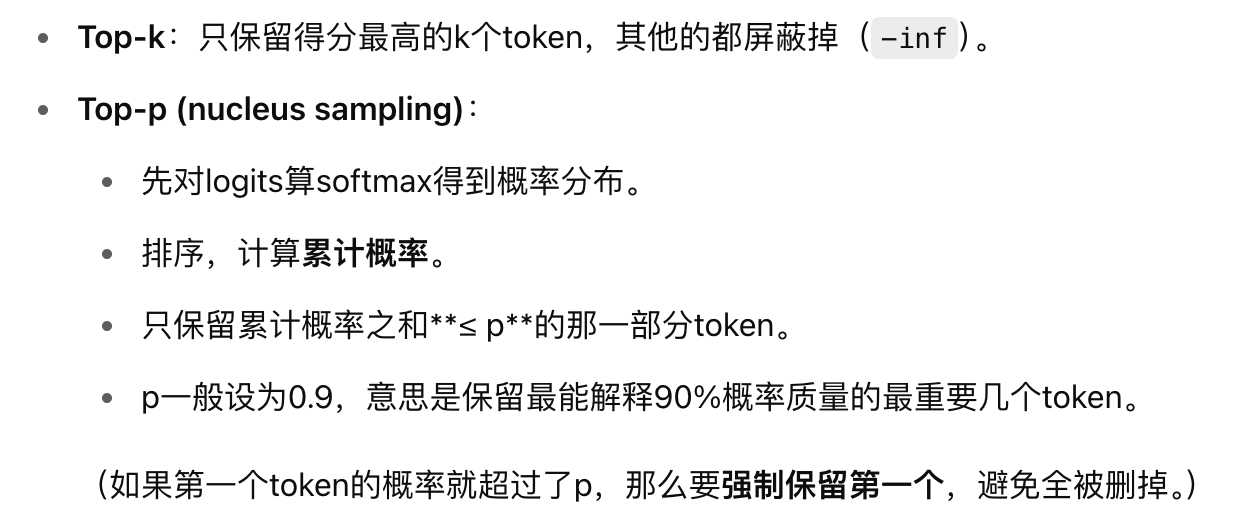

In [39]:
def filter_topk_topp(logits: torch.Tensor, k=50, p=0.9) -> torch.Tensor: 
    '''
    Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
    '''
    assert logits.dim() == 1
    logits = logits.clone()

    if k > 0:
        ### START YOUR CODE ###
        topk_logits, topk_indices = torch.topk(logits, k)
        # Create a mask for logits to remove (those not in top-k)
        logits_to_remove = logits < topk_logits[-1]
        logits[logits_to_remove] = -float('Inf')
        ### END YOUR CODE ###
    
    if p > 0.0:
        ### START YOUR CODE ###
        logits_sorted, indices_sorted = torch.sort(logits, descending=True) # Hint: Sort logits in ascending order
        probs = torch.softmax(logits_sorted, dim=-1)
        cum_probs = torch.cumsum(probs, dim=-1) # Hint: first convert logits to probabilities, then compute cumulative probabilities
        indices_to_remove = cum_probs > p
        # It is possible that cum_probs[0] > p, in which case all logits will be removed
        # we want to avoid that, so always keep the first logit
        if cum_probs[0] > p:
            indices_to_remove[1:] = indices_to_remove[:-1].clone()
            indices_to_remove[0] = False 

        indices_to_remove = indices_sorted[indices_to_remove]
        logits[indices_to_remove] = -float('Inf')
        ### END YOUR CODE ### 

    
    return logits

In [41]:
# Test filter_topk_topp
logits = torch.tensor(list(range(10))).float()
print('original logits:', logits)

logits2 = filter_topk_topp(logits, k=5, p=0.0)
print('\nk=5, p=0.0:', logits2)

logits3 = filter_topk_topp(logits, k=0, p=0.9)
print('\nk=0, p=0.9:', logits3)

logits4 = filter_topk_topp(logits, k=0, p=0.9999999)
print('\nk=0, p=0.9999999:', logits4)

logits5 = filter_topk_topp(logits, k=5, p=0.9999999)
print('\nk=5, p=0.9999999:', logits5)


# You are expected to see the following output:
# original logits: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
# k=5, p=0.0: tensor([-inf, -inf, -inf, -inf, -inf, 5., 6., 7., 8., 9.])
# k=0, p=0.9: tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 8., 9.])
# k=0, p=0.9999999: tensor([-inf, 1., 2., 3., 4., 5., 6., 7., 8., 9.])
# k=5, p=0.9999999: tensor([-inf, -inf, -inf, -inf, -inf, 5., 6., 7., 8., 9.])

original logits: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

k=5, p=0.0: tensor([-inf, -inf, -inf, -inf, -inf, 5., 6., 7., 8., 9.])

k=0, p=0.9: tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 8., 9.])

k=0, p=0.9999999: tensor([-inf, 1., 2., 3., 4., 5., 6., 7., 8., 9.])

k=5, p=0.9999999: tensor([-inf, -inf, -inf, -inf, -inf, -inf, 6., 7., 8., 9.])


In the following test, if all logits are `-inf`, then your top-p sampling is not correctly implemented. 

You wan to keep at least one element in the logits, whose logit value dominates the distribution. 

In [16]:
logits_special = torch.tensor(np.arange(10)**2).float()
print('original logits:', logits_special)

logits6 = filter_topk_topp(logits_special, k=0, p=0.9)
print('\nk=0, p=0.9:', logits6)


# You are expected to see the following output:
# original logits: tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.])
# k=0, p=0.9: tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 81.])

original logits: tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.])

k=0, p=0.9: tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 81.])


Finally, we integrate the filtering to the generation process.

In [17]:
def generate_topk_topp(input_text, k=50, p=0.9, max_gen_len=20):
    '''
    Generate tokens from the top-k and top-p filtered logits, and yield the sampled token id.
    '''
    input_encoded = gpt2_tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
    input_ids = input_encoded.input_ids
    attn_mask = input_encoded.attention_mask

    count = 0
    while count < max_gen_len:
        output = gpt2_model(input_ids, attention_mask=attn_mask)
        logits = output.logits

        # Get last token logits
        ### START YOUR CODE ###
        last_token_logits = logits[:, -1, :].squeeze()
        ### END YOUR CODE ###

        # Get the filtered logits by calling filter_topk_topp 
        ### START YOUR CODE ###
        filtered_logits = filter_topk_topp(last_token_logits, k=k, p=p)
        ### END YOUR CODE ###


        # Sample from the remaining tokens in sorted_logits
        ### START YOUR CODE ###
        filtered_probs = torch.softmax(filtered_logits, dim=-1) # Hint: Convert logits to probabilities
        
        sampled_index = torch.multinomial(filtered_probs, num_samples=1).item() # Hint: Sample proportionally from the filtered_probs, similar to what's done in generate_topk_proportion()


        # Yield the sampled token id
        yield sampled_index
        if sampled_index == gpt2_tokenizer.sep_token_id:
            break

        # Append the sampled token id to the input_ids, and extend the attention mask
        input_ids = torch.cat([
            input_ids, 
            torch.tensor([[sampled_index]], device=input_ids.device)
        ], dim=-1)
        attn_mask = torch.cat([
            attn_mask,
            torch.tensor([[1]], device=attn_mask.device)
        ], dim=-1)
        ### END YOUR CODE ###

        count += 1

In [18]:
# Test
input_text = "今天天气"
print(input_text, end='')
for tok_id in generate_topk_topp(input_text, k=50, p=0.95):
    print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end='')

今天天气热、多风，还需要带大衣、毛裤、秋裤。如果

In [19]:
# Test
input_text = "子曰：人"
print(input_text, end='')
for tok_id in generate_topk_topp(input_text, k=50, p=0.95):
    print(gpt2_tokenizer.convert_ids_to_tokens(tok_id), end='')

子曰：人间有事做，请别忙。所以，在别人眼里，我们